In [14]:
import random
import torch
import torch_geometric

import torch.nn.functional as F
import sys
import os

from rdkit import Chem
from tqdm import tqdm
from copy import deepcopy

from concurrent.futures import ThreadPoolExecutor, as_completed
import concurrent
from concurrent.futures import ProcessPoolExecutor, as_completed

from pathlib import Path

cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)
sys.path.append(parent_dir)

from torch_scatter import scatter_max, scatter_add

from DataPipeline.preprocessing import process_encode_graph, get_subgraph_with_terminal_nodes_step
from DataPipeline.preprocessing import node_encoder
from Model.GNN1 import ModelWithEdgeFeatures as GNN1
from Model.GNN1 import ModelWithNodeConcat as GNN1_node_concat
from Model.GNN2 import ModelWithEdgeFeatures as GNN2
from Model.GNN2 import ModelWithNodeConcat as GNN2_node_concat
from Model.GNN3 import ModelWithEdgeFeatures as GNN3
from Model.GNN3 import ModelWithgraph_embedding_modif as GNN3_embedding

In [15]:
def tensor_to_smiles(node_features, edge_index, edge_attr, edge_mapping = 'aromatic', encoding_type = 'charged'):
    # Create an empty editable molecule
    mol = Chem.RWMol()

    # Define atom mapping
    if encoding_type == 'charged':
        
        atom_mapping = {
            0: ('C', 0),
            1: ('N', 0),
            2: ('N', 1),
            3: ('N', -1),
            4: ('O', 0),
            5: ('O', -1),
            6: ('F', 0),
            7: ('S', 0),
            8: ('S', -1),
            9: ('Cl', 0),
            10: ('Br', 0),
            11: ('I', 0)
        }

    elif encoding_type == 'polymer':
        atom_mapping = {
            0: ('C', 0),
            1: ('N', 0),
            2: ('O', 0),
            3: ('F', 0),
            4: ('Si', 0),
            5: ('P', 0),
            6: ('S', 0)}

    # Add atoms
    for atom_feature in node_features:
        atom_idx = atom_feature[:12].argmax().item()
        atom_symbol, charge = atom_mapping.get(atom_idx)
        atom = Chem.Atom(atom_symbol)
        atom.SetFormalCharge(charge)
        mol.AddAtom(atom)

    # Define bond type mapping
    if edge_mapping == 'aromatic':
        bond_mapping = {
            0: Chem.rdchem.BondType.AROMATIC,
            1: Chem.rdchem.BondType.SINGLE,
            2: Chem.rdchem.BondType.DOUBLE,
            3: Chem.rdchem.BondType.TRIPLE,
        }
    elif edge_mapping == 'kekulized':
        bond_mapping = {
            0: Chem.rdchem.BondType.SINGLE,
            1: Chem.rdchem.BondType.DOUBLE,
            2: Chem.rdchem.BondType.TRIPLE,
        }

    # Add bonds
    for start, end, bond_attr in zip(edge_index[0], edge_index[1], edge_attr):
        bond_type_idx = bond_attr[:4].argmax().item()
        bond_type = bond_mapping.get(bond_type_idx)

        # RDKit ignores attempts to add a bond that already exists,
        # so we need to check if the bond exists before we add it
        if mol.GetBondBetweenAtoms(start.item(), end.item()) is None:
            mol.AddBond(start.item(), end.item(), bond_type)

    # Convert the molecule to SMILES
    smiles = Chem.MolToSmiles(mol)

    return smiles

import torch
from torch_geometric.data import Batch

def sample_first_atom_batch(batch_size, encoding = 'reduced'):
    if encoding == 'reduced' or encoding == 'charged':
        prob_dict = {'60': 0.7385023585929047, 
                    '80': 0.1000143018658728, 
                    '70': 0.12239949901813525, 
                    '90': 0.013786373862576426, 
                    '160': 0.017856330814654413,
                    '170': 0.007441135845856433}
    if encoding == 'polymer':
        prob_dict = {'60': 0.7489344573582472,
                    '70': 0.0561389266682314,
                    '80': 0.0678638375933265,
                    '160': 0.08724385192820308,
                    '90': 0.032130486119902095,
                    '140': 0.007666591133009364,
                    '150': 2.184919908044154e-05}

    atoms = [random.choices(list(prob_dict.keys()), weights=list(prob_dict.values()))[0] for _ in range(batch_size)]
    return atoms

def create_torch_graph_from_one_atom_batch(atoms, edge_size, encoding_option='reduced') -> list:
    graphs = []
    for atom in atoms:
        num_atom = int(atom)
        atom_attribute = node_encoder(num_atom, encoding_option=encoding_option)
        # Create graph
        # Increase the size of atom_attribute by one 
        atom_attribute = torch.cat((atom_attribute, torch.zeros(1)), dim=0)
        graph = torch_geometric.data.Data(x=atom_attribute.view(1, -1), edge_index=torch.empty((2, 0), dtype=torch.long), edge_attr=torch.empty((0, edge_size)))
        graphs.append(graph)
            
    
    return Batch.from_data_list(graphs)


In [16]:



# Function to check the valence of the nodes in the graph

def check_valence(graph, list_nodes):

    for node in list_nodes:
        # Get the type of the node
        node_type = torch.argmax(graph.x[node])

        # Compute the valence of each node by summing the bond types of all edges connected to the node
        bond_types = torch.argmax(graph.edge_attr, dim=1) + 1  # add 1 to count single bonds as 1, etc.
        valences = torch.bincount(graph.edge_index[0], weights=bond_types)

        # Check if the valence is superior to the limit
        if node_type == 0:
            max_valence = 4
        elif node_type == 1:
            max_valence = 3
        elif node_type == 4:
            max_valence = 2
        else:
            max_valence = 6

        if valences[node].item() > max_valence:
            # Get the indice of the graph whose node is in excess
            graph_indice = graph.batch[node].item()
            extract_one_graph(graph, graph_indice)
            raise ValueError(f"Valence of node {node} is superior to {max_valence}")

import numpy as np
    
def extract_one_graph(batch, graph_indice):
    
        # Create a mask of booleans
        mask = batch.batch == graph_indice
        
        # Extract all the node features that correspond to the i-th graph
        subgraph_x = batch.x[mask]
        # Create a mapping of the corresponding indices from the big graph to the individual graph

        indices_mapping = {j.item(): k for k, j in enumerate(torch.where(mask)[0])}
        mapping_func = np.vectorize(indices_mapping.get)

        # Extract all the edges that correspond to the i-th graph
        edge_mask = mask[batch.edge_index[0]] & mask[batch.edge_index[1]]
        subgraph_edge_index = torch.tensor(mapping_func(batch.edge_index[:, edge_mask].cpu().numpy()), dtype=torch.long)

        # Extract all the edge features that correspond to the i-th graph

        
        if batch.edge_attr is not None:
            subgraph_edge_attr = batch.edge_attr[edge_mask]
        else:
            subgraph_edge_attr = None

In [17]:
def return_current_nodes_batched(current_node_tensor, graph_batch):
    # Get the unique graph ids
    batch = graph_batch.batch
    unique_graph_ids = torch.unique(batch)
    # Create a 2D mask that shows where each graph's nodes are located in batch
    mask = batch[None, :] == unique_graph_ids[:, None]
    # Compute the cumulative sum of the mask along the second dimension
    cumulative_mask = mask.cumsum(dim=1)
    # Now, for each graph, the nodes are numbered from 1 to N (or 0 to N-1 if we subtract 1)
    node_indices_per_graph = cumulative_mask - 1
    # But we only want the indices of certain nodes (specified by current_node_tensor)
    # So we create a mask that is True where the node index equals the current node index for the graph
    current_node_mask = node_indices_per_graph == current_node_tensor[:, None]
    # The result is the indices in batch where current_node_mask is True
    # Find the arg of the first True in each row
    result = torch.argmax(current_node_mask.int(), dim=1)
    return result

def set_last_nodes(batch, last_prediction_size):
    # Reset the current node column
    batch.x[:, -2] = 0
    # Set the last nodes to 1
    batch.x[batch.x.shape[0] - last_prediction_size:, -2] = 1
    return batch

def increment_feature_position(batch, current_nodes_batched, stop_mask):

    stopped_current_nodes = current_nodes_batched[stop_mask]

    batch.x[stopped_current_nodes, -1] = 1

    return batch




def create_mask(batch_graph, current_nodes_tensor : torch.tensor, last_prediction_size):
    # Create a mask for the current nodes tensor    
    feature_postion = batch_graph.x[:, -1]
    mask = torch.logical_not(feature_postion.bool())
    # Set the last nodes to False
    mask[batch_graph.x.shape[0] - last_prediction_size:] = False
    # Set the current nodes to False
    mask[current_nodes_tensor] = False

    return mask



def select_node_batch(prediction, batch_data, edge_size, mask):

    # Sum on the first dimensions of each vector
    sum_on_first_dims = prediction[:, :edge_size - 1].sum(dim=1)
    unique_graph_ids = torch.unique(batch_data)
    expanded_sum = sum_on_first_dims[None, :].expand(unique_graph_ids.shape[0], -1)
    
    # Create a 2D mask that shows where each graph's nodes are located in batch
    mask_location = batch_data[None, :] == unique_graph_ids[:, None]
    # Apply the mask to each row of mask_location
    mask = mask_location * mask[None, :]
    # Apply mask to the sum tensor, setting masked values to -inf
    masked_sum = expanded_sum.masked_fill(~mask,float ('-inf'))
    #Find the max value in each row
    max_indices = torch.argmax(masked_sum, dim=1)
    # Create a count mask that counts how many True values there are in each row
    count_mask = mask.sum(dim=1)

    # Replace indices where there were no True values in the mask with -1 (or any value you want)
    minus_one = torch.tensor([-1], device=max_indices.device)
    max_indices = max_indices.where(count_mask > 0, minus_one)
    # Sample using the tensor using the multinomial function
    sampled_indices = prediction.multinomial(num_samples=1).squeeze()
    # Replace -1 values in max_indices with the corresponding sampled_indices
    final_indices = torch.where(max_indices != -1, sampled_indices[max_indices], prediction.size(1) - 1)

    return final_indices, max_indices

def add_nodes_and_edges_batch(batch, new_nodes, new_edges, current_nodes_batched, mask):

    device = batch.x.device
    # Add one zero to the end of the new_nodes
    new_nodes = torch.cat([new_nodes, torch.zeros(new_nodes.size(0), 1, device=new_nodes.device)], dim=1)
    # Add new nodes to the node attributes, considering the mask
    new_nodes_masked = new_nodes[mask]
    batch.x = torch.cat([batch.x, new_nodes_masked], dim=0)

    # Create new edges between the current nodes and the new nodes in a bidirectional manner
    num_new_nodes = new_nodes_masked.shape[0]
    new_edge_indices = torch.stack([current_nodes_batched[mask], torch.arange(batch.num_nodes - num_new_nodes, batch.num_nodes, device=device)], dim=0)
    new_edge_indices = torch.cat([new_edge_indices, new_edge_indices.flip(0)], dim=1)  # Making the edges bidirectional

    # Adding the new edges to the edge_index
    batch.edge_index = torch.cat([batch.edge_index, new_edge_indices], dim=1)

    # Create new edge attributes and mask out the entries where mask is False
    new_edge_attrs = new_edges[mask].repeat(2, 1)

    # Adding the new edge attributes to the edge attributes
    batch.edge_attr = torch.cat([batch.edge_attr, new_edge_attrs], dim=0)

    # Update the batch.batch tensor
    new_batch_entries = torch.arange(new_nodes.shape[0], device=device)
    batch.batch = torch.cat([batch.batch, new_batch_entries[mask]])
    #check_valence(batch, torch.arange(batch.num_nodes - num_new_nodes, batch.num_nodes, device=device).tolist())
    #check_valence(batch, current_nodes_batched[mask].tolist())
    # Return the updated batch
    return batch

def add_edges_and_attributes(batch, edges_predicted, indices, mask, stopping_mask):

    num_new_edges = edges_predicted.shape[0]
    mask_edge_predicted = edges_predicted[mask]
    mask_indices = indices[mask]
    
    num_new_nodes = torch.sum(stopping_mask)
    last_indices = torch.arange(batch.num_nodes - num_new_nodes, batch.num_nodes, device=batch.x.device)

    last_nodes_batch = torch.full(stopping_mask.shape, -1, device=batch.x.device)

    last_nodes_batch[stopping_mask] = last_indices

    new_edges_indices = torch.stack([mask_indices, last_nodes_batch[mask]], dim=0)
    new_edges_indices = torch.cat([new_edges_indices, new_edges_indices.flip(0)], dim=1)  # Making the edges bidirectional

    # Adding the new edges to the edge_index
    batch.edge_index = torch.cat([batch.edge_index, new_edges_indices], dim=1)

    # Create new edge attributes and mask out the entries where mask is False
    new_edge_attrs = mask_edge_predicted.repeat(2, 1)

    # Adding the new edge attributes to the edge attributes
    batch.edge_attr = torch.cat([batch.edge_attr, new_edge_attrs], dim=0)

    #check_valence(batch, mask_indices.tolist())
    #check_valence(batch, last_indices.tolist())

    return batch

In [18]:
import numpy as np
from torch_geometric.data import Data
def extract_all_graphs(batch):
    all_graphs = []
    nb_graphs = batch.batch.max().item() + 1

    for i in range(nb_graphs):
        # Create a mask of booleans
        mask = batch.batch == i
        
        # Extract all the node features that correspond to the i-th graph
        subgraph_x = batch.x[mask]
        # Create a mapping of the corresponding indices from the big graph to the individual graph

        indices_mapping = {j.item(): k for k, j in enumerate(torch.where(mask)[0])}
        mapping_func = np.vectorize(indices_mapping.get)

        # Extract all the edges that correspond to the i-th graph
        edge_mask = mask[batch.edge_index[0]] & mask[batch.edge_index[1]]

        if edge_mask.sum() == 0:
            subgraph_edge_index = torch.tensor([], dtype=torch.long)
        else:
            subgraph_edge_index = torch.tensor(mapping_func(batch.edge_index[:, edge_mask].cpu().numpy()), dtype=torch.long)

        # Extract all the edge features that correspond to the i-th graph

        
        if batch.edge_attr is not None:
            subgraph_edge_attr = batch.edge_attr[edge_mask]
        else:
            subgraph_edge_attr = None

        # Construct the subgraph
        subgraph = Data(x=subgraph_x, edge_index=subgraph_edge_index, edge_attr=subgraph_edge_attr)
        # Append the subgraph to the list
        all_graphs.append(subgraph)

    return all_graphs

In [19]:
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx

def check_connectivity(batch):

    graph = Data(x=batch.x, edge_index=batch.edge_index, edge_attr=batch.edge_attr)


    # Assuming data is your torch_geometric data object
    G = to_networkx(graph) # Convert to a networkx graph
    # Get the connected components (independent subgraphs)
    components = nx.weakly_connected_components(G)
    # Count the number of independent subgraphs
    num_subgraphs = len(list(components))

    return num_subgraphs

In [20]:
def load_model(checkpoint_path, model, optimizer):

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return model, optimizer

def get_model_GNN1(config, encoding_size, edge_size):

    return GNN1(in_channels=encoding_size + int(config['feature_position'] + int(len(config['score_list']))),
                hidden_channels_list=config["GCN_size"],
                mlp_hidden_channels=config['mlp_hidden'],
                edge_channels=edge_size, 
                num_classes=encoding_size, 
                use_dropout=config['use_dropout'],
                size_info=config['use_size'],
                max_size=config['max_size'])

def get_model_GNN2(config, encoding_size, edge_size):

    return GNN2(in_channels=encoding_size + int(config['feature_position'] + int(len(config['score_list']))),
                hidden_channels_list=config["GCN_size"],
                mlp_hidden_channels=config['mlp_hidden'],
                edge_channels=edge_size, 
                num_classes=edge_size, 
                size_info=config['use_size'],
                max_size=config['max_size'],
                use_dropout=config['use_dropout'])

def get_model_GNN3(config, encoding_size, edge_size):

    if config['graph_embedding']:
        return GNN3_embedding(in_channels=encoding_size + int(config['feature_position'] + int(len(config['score_list']))),
                    hidden_channels_list=config["GCN_size"],
                    mlp_hidden_channels = config['mlp_hidden'],
                    edge_channels=edge_size, 
                    num_classes=edge_size,
                    use_dropout=config['use_dropout'],
                    size_info=config['use_size'],
                    max_size=config['max_size'])

    return GNN3(in_channels=encoding_size + int(config['feature_position'] + int(len(config['score_list']))),
                hidden_channels_list=config["GCN_size"],
                edge_channels=edge_size, 
                use_dropout=config['use_dropout'])

def get_optimizer(model, lr):
    return torch.optim.Adam(model.parameters(), lr=lr)


def add_score_features(subgraph, scores_list, desired_scores_list, GNN_type = 1):

    if scores_list != []:
        assert len(scores_list) == len(desired_scores_list) 
        # Concat the scores to the node features
        for i, score in enumerate(scores_list):
            score_tensor = torch.tensor(desired_scores_list[i], dtype=torch.float).view(1, 1)
            # Duplicate the score tensor to match the number of nodes in the subgraph
            score_tensor = score_tensor.repeat(subgraph.x.size(0), 1)
            subgraph.x = torch.cat([subgraph.x, score_tensor], dim=-1)
        if GNN_type == 2:
            subgraph.neighbor = torch.cat([subgraph.neighbor, torch.zeros((1, len(scores_list)))], dim=-1)
    return subgraph


class MolGenBatchFaster():
    def __init__(self, GNN1, GNN2, GNN3, encoding_size, edge_size, batch_size, feature_position, device, save_intermidiate_states = False, encoding_option = 'charged', score_list = [], desired_score_list = []):

        batch_mol_graph = create_torch_graph_from_one_atom_batch(sample_first_atom_batch(batch_size = batch_size, encoding = encoding_option), edge_size=edge_size, encoding_option=encoding_option)
        self.batch_mol_graph = batch_mol_graph.to(device) # Encoded in size 14 for the feature position
        self.queues = torch.zeros(batch_size, dtype=torch.long, device=device)
        self.node_counts = torch.zeros(batch_size, dtype=torch.long, device=device)
        self.finished_mask = torch.zeros(batch_size, dtype=torch.bool, device=device)
        self.batch_size = batch_size
        self.GNN1 = GNN1
        self.GNN2 = GNN2
        self.GNN3 = GNN3
        self.device = device
        self.feature_position = feature_position
        self.encoding_size = encoding_size
        self.edge_size = edge_size
        self.save_intermidiate_states = save_intermidiate_states
        if save_intermidiate_states:
            self.intermidiate_states = []

        self.score_list = score_list
        self.desired_score_list = desired_score_list

    def one_step(self):
        with torch.no_grad():
            
            current_nodes = self.queues.clone()
            
            # Get the molecules that are finished which means that the number in the queue is superior to the number of nodes in the molecule
            old_finished_mask = self.finished_mask
            self.finished_mask = current_nodes > self.node_counts

            # test if no molecule has changed from finished to unfinished
            if torch.any(old_finished_mask & ~self.finished_mask):
                print('error')
                raise ValueError('error')
            # If all the mask is True, then all the molecules are finished
            if torch.all(self.finished_mask):
                print('all finished')
                return 
            """
            Prepare the GNN 1 BATCH
            """
            current_nodes[self.finished_mask] = current_nodes[self.finished_mask] - 1
            current_nodes_batched = return_current_nodes_batched(current_nodes, self.batch_mol_graph) #reindex the nodes to match the batch size
            
            self.batch_mol_graph.x[: , -2] = 0
            # Do you -1 for the current nodes that are finished

            self.batch_mol_graph.x[current_nodes_batched, -2] = 1
            predictions = self.GNN1(self.batch_mol_graph)
            
            # Apply softmax to prediction
            softmax_predictions = F.softmax(predictions, dim=1)

            # Sample next node from prediction
            predicted_nodes = torch.multinomial(softmax_predictions, num_samples=1)

            # Create a mask for determining which graphs should continue to GNN2
            mask_gnn2 = (predicted_nodes != self.encoding_size - 1).flatten()

            # Handle the stopping condition (where predicted_node is encoding_size - 1)
            stop_mask = (predicted_nodes == self.encoding_size - 1).flatten()
            
            # If it's the first epoch and all the first nodes are stop nodes, then print an error
            if torch.any(stop_mask) and self.node_counts.sum() == 0:
                print('error')
                # print the prediction of the one that is a stop node
                print(softmax_predictions[stop_mask])
                # print the x of the one that is a stop node
                print(self.batch_mol_graph.x[stop_mask])
            # Increment the node count for graphs that haven't stopped and that are not finished
            self.node_counts = self.node_counts + torch.logical_and(~stop_mask, ~self.finished_mask).long()

            # Increment the queue for graphs that have been stopped and that are not finished
            
            self.queues = self.queues + torch.logical_and(stop_mask, ~self.finished_mask).long()

            # Increment the feature position for graphs that have been stopped

            self.batch_mol_graph = increment_feature_position(self.batch_mol_graph, current_nodes_batched, stop_mask)

            # Encode next node for the entire batch
            encoded_predicted_nodes = torch.zeros(predictions.size(), device=self.device, dtype=torch.float)
            encoded_predicted_nodes.scatter_(1, predicted_nodes, 1)

            #GNN2 
                    
            # add zeros to the neighbor because of the feature position
            encoded_predicted_nodes = torch.cat([encoded_predicted_nodes, torch.zeros(self.batch_size, 1).to(encoded_predicted_nodes.device)], dim=1)

            self.batch_mol_graph.neighbor = encoded_predicted_nodes

            predictions2 = self.GNN2(self.batch_mol_graph)
            predicted_edges = torch.multinomial(F.softmax(predictions2, dim=1), num_samples=1)

            encoded_predicted_edges = torch.zeros_like(predictions2, device=self.device, dtype=torch.float)
            encoded_predicted_edges.scatter_(1, predicted_edges, 1)
            
            # Create a new node that is going to be added to the graph for each batch
            new_nodes = torch.zeros(self.batch_size, self.encoding_size, device=self.device, dtype=torch.float)
            new_nodes.scatter_(1, predicted_nodes, 1)
            #GNN3

            # Add the node and the edge to the graph
            self.batch_mol_graph = add_nodes_and_edges_batch(self.batch_mol_graph, new_nodes, encoded_predicted_edges, current_nodes_batched, torch.logical_and(mask_gnn2, ~self.finished_mask))
            

            self.batch_mol_graph = set_last_nodes(self.batch_mol_graph, torch.sum(torch.logical_and(mask_gnn2, ~self.finished_mask), dim=0))            
            mask = create_mask(self.batch_mol_graph, current_nodes_tensor = current_nodes_batched, last_prediction_size=torch.sum(torch.logical_and(mask_gnn2, ~self.finished_mask), dim=0))
            self.batch_mol_graph.mask = mask
        
            prediction3 = self.GNN3(self.batch_mol_graph)
            
            softmax_prediction3 = F.softmax(prediction3, dim=1)
            edges_predicted, max_indices = select_node_batch(softmax_prediction3, self.batch_mol_graph.batch, self.edge_size, mask)
            encoded_edges_predicted = torch.zeros((edges_predicted.shape[0], self.edge_size), device=self.device, dtype=torch.float)

            encoded_edges_predicted.scatter_(1, edges_predicted.unsqueeze(1), 1)

            update_mask = torch.where(edges_predicted == self.edge_size - 1, torch.zeros_like(edges_predicted), torch.ones_like(edges_predicted)).bool()

            total_mask = torch.logical_and(torch.logical_and(update_mask, mask_gnn2), ~self.finished_mask)

            self.mol_graphs_list = add_edges_and_attributes(self.batch_mol_graph, encoded_edges_predicted, max_indices, total_mask, torch.logical_and(mask_gnn2, ~self.finished_mask))


    def full_generation(self):
        max_iter = 150
        i = 0
        while torch.all(self.finished_mask) == False:
            if i > max_iter:
                break
            self.one_step()
            i += 1
            if self.save_intermidiate_states:
                self.intermidiate_states.append(self.mol_graph.clone())
        
    def is_valid(self):
        if self.edge_size == 3:
            edge_mapping = 'kekulized'
        else:
            edge_mapping = 'aromatic'
        SMILES_str = tensor_to_smiles(self.mol_graph.x, self.mol_graph.edge_index, self.mol_graph.edge_attr, edge_mapping, encoding_type=self.encoding_type)
        mol = Chem.MolFromSmiles(SMILES_str)
        if mol is None:
            return False
        else:
            return True


class GenerationModuleBatchFaster():
    def __init__(self, config1, config2, config3, encoding_size, edge_size, pathGNN1, pathGNN2, pathGNN3, checking_mode = False, encoding_type = 'charged', batch_size = 64, score_list = [], desired_score_list = []):
        self.config1 = config1
        self.config2 = config2
        self.config3 = config3
        self.encoding_size = encoding_size
        self.edge_size = edge_size
        self.batch_size = batch_size
        self.encoding_type = encoding_type
        self.feature_position = config1["feature_position"]
        self.checking_mode = checking_mode

        self.score_list = config1["score_list"]
        self.desired_score_list = desired_score_list

        if self.checking_mode:
            self.non_valid_molecules = []

        self.GNN1 = get_model_GNN1(config1, encoding_size, edge_size)
        self.GNN2 = get_model_GNN2(config2, encoding_size, edge_size)
        self.GNN3 = get_model_GNN3(config3, encoding_size, edge_size)

        self.optimizer_GNN1 = torch.optim.Adam(self.GNN1.parameters(), lr=config1["lr"])
        self.optimizer_GNN2 = torch.optim.Adam(self.GNN2.parameters(), lr=config2["lr"])
        self.optimizer_GNN3 = torch.optim.Adam(self.GNN3.parameters(), lr=config3["lr"])

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.GNN1_model, self.optimizer_GNN1 = load_model(pathGNN1, self.GNN1, self.optimizer_GNN1)
        self.GNN2_model, self.optimizer_GNN2 = load_model(pathGNN2, self.GNN2, self.optimizer_GNN2)
        self.GNN3_model, self.optimizer_GNN3 = load_model(pathGNN3, self.GNN3, self.optimizer_GNN3)

        self.GNN1_model.to(self.device)
        self.GNN2_model.to(self.device)
        self.GNN3_model.to(self.device)

        self.GNN1_model.eval()
        self.GNN2_model.eval()
        self.GNN3_model.eval()
    
    def generate_single_molecule(self):
        mol = MolGenBatchFaster(self.GNN1_model,
                     self.GNN2_model,
                     self.GNN3_model,
                     self.encoding_size,
                     self.edge_size,
                     self.batch_size,
                     self.feature_position,
                     self.device,
                     save_intermidiate_states=self.checking_mode,
                     encoding_option=self.encoding_type,
                     score_list=self.score_list,
                     desired_score_list=self.desired_score_list)
        mol.full_generation()
             
        finished_batch = mol.batch_mol_graph
        # Extract molecules from the batch
        mol_list = extract_all_graphs(finished_batch)
        return mol_list


    def generate_mol_list(self, n_mol, n_threads=1):
        mol_list = []
        if n_threads == 1:
            for i in tqdm(range(n_mol), desc="Generating molecules"):
                mol_graph = self.generate_single_molecule()
                mol_list += mol_graph
        else:

            # Utilize ThreadPoolExecutor to parallelize the task
            with ThreadPoolExecutor(max_workers=n_threads) as executor:
                # Submit tasks to the thread pool
                future_to_mol = {executor.submit(self.generate_single_molecule): i for i in range(n_mol)}
                
                # Collect the results as they become available
                for future in tqdm(as_completed(future_to_mol), total=n_mol, desc="Generating molecules"):
                    mol_graph = future.result()
                    mol_list.append(mol_graph)
                    
        return mol_list


In [21]:
# All paths 

GENERATED_SAVING_DIR = Path('..') / 'generated_mols' / 'raw'
SCORED_SAVING_DIR = Path('..') / 'generated_mols' / 'scored'
ZINC_DATA_PATH = SCORED_SAVING_DIR / 'scored_zinc.csv'

SAVE_RESULTS_PATH = Path('..') / 'generate_analyse_mols' / 'results'

In [22]:
def load_best_models(path):
    with open(path/'six_best_epochs.txt', 'r') as f:
        lines = f.readlines()
        epoch_values = [float(line.split(' ')[1]) for line in lines]
        best_line_index = epoch_values.index(max(epoch_values))
        loss_value = float(lines[best_line_index].split(' ')[-1])
    print('Loading best checkpoint number {} of the epoch {} with a loss of {}'.format(best_line_index, epoch_values[best_line_index], loss_value))
    checkpoint_path = path / 'history_training' / f'checkpoint_{best_line_index}.pt'
    return checkpoint_path

In [23]:
experiment_name = 'GNN_baseline'
experiment_path = Path('..') / 'trained_models' / experiment_name

In [24]:
import json
import pyinstrument
# List the folders in the experiment path

folders = os.listdir(experiment_path)
for folder in folders:
    if folder.startswith('GNN1'):
        GNN1_path = experiment_path / folder 
    elif folder.startswith('GNN2'):
        GNN2_path = experiment_path / folder
    elif folder.startswith('GNN3'):
        GNN3_path = experiment_path / folder

# Read the config as a json

config1_path = GNN1_path / 'parameters.json'
config2_path = GNN2_path / 'parameters.json'
config3_path = GNN3_path / 'parameters.json'

with open(config1_path, 'r') as f:
    config1 = json.load(f)
with open(config2_path, 'r') as f:
    config2 = json.load(f)
with open(config3_path, 'r') as f:
    config3 = json.load(f)

# Open the models with the best loss on the validation set


GNN1_path = load_best_models(GNN1_path)
GNN2_path = load_best_models(GNN2_path)
GNN3_path = load_best_models(GNN3_path)

print(GNN1_path, GNN2_path, GNN3_path)

encoding_size = 13


edge_size = 3


module = GenerationModuleBatchFaster(config1=config1, 
                        config2=config2, 
                        config3=config3, 
                        encoding_size = encoding_size,
                        edge_size = edge_size, 
                        pathGNN1=GNN1_path, 
                        pathGNN2=GNN2_path, 
                        pathGNN3=GNN3_path,
                        encoding_type='charged',
                        batch_size = 2000,
                        desired_score_list=[])

print('Generating molecules...')
# time the function with pyinstrument
with pyinstrument.Profiler() as prof:
    graph_batch = module.generate_mol_list(1)

print(prof.output_text(unicode=True, color=True))

Loading best checkpoint number 1 of the epoch 2050.0 with a loss of 0.5107812829972882
Loading best checkpoint number 1 of the epoch 2550.0 with a loss of 0.1984780294417413
Loading best checkpoint number 0 of the epoch 3000.0 with a loss of 0.05697827504829092
..\trained_models\GNN_baseline\GNN1_baseline\history_training\checkpoint_1.pt ..\trained_models\GNN_baseline\GNN2_baseline\history_training\checkpoint_1.pt ..\trained_models\GNN_baseline\GNN3_baseline\history_training\checkpoint_0.pt


Generating molecules...


Generating molecules:   0%|          | 0/1 [00:00<?, ?it/s]

all finished


Generating molecules: 100%|██████████| 1/1 [00:40<00:00, 40.01s/it]



  _     ._   __/__   _ _  _  _ _/_   Recorded: 20:36:28  Samples:  6108
 /_//_/// /_\ / //_// / //_'/ //     Duration: 40.014    CPU time: 39.156
/   _/                      v4.4.0

Program: c:\Users\goupi\.conda\envs\torch_geometric\lib\site-packages\ipykernel_launcher.py --ip=127.0.0.1 --stdin=9003 --control=9001 --hb=9000 --Session.signature_scheme="hmac-sha256" --Session.key=b"432c8bde-b284-4cd1-aee4-33c8d7124746" --shell=9002 --transport="tcp" --iopub=9004 --f=c:\Users\goupi\AppData\Roaming\jupyter\runtime\kernel-v2-23784lmrqzgq9JJBz.json

40.014 <module>  ..\..\..\AppData\Local\Temp\ipykernel_1120\2643807165.py:1
└─ 40.014 GenerationModuleBatchFaster.generate_mol_list  ..\..\..\AppData\Local\Temp\ipykernel_1120\4070346039.py:278
   └─ 40.008 GenerationModuleBatchFaster.generate_single_molecule  ..\..\..\AppData\Local\Temp\ipykernel_1120\4070346039.py:257
      ├─ 36.380 MolGenBatchFaster.full_generation  ..\..\..\AppData\Local\Temp\ipykernel_1120\4070346039.py:194
      │  └─ 36

00:24 4*250
00:18 1*1000
1:12 1*4000
1:23 4*1000

3.545 global add pool gnn1
1.374

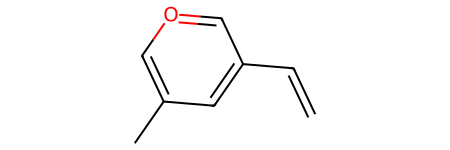

In [25]:
Chem.MolFromSmiles('C=CC1=CC(C)=CO=C1', sanitize=False)

In [26]:
extracted_graphs = extract_all_graphs(graph_batch)

AttributeError: 'list' object has no attribute 'batch'

In [27]:
extracted_graphs[0].edge_index

NameError: name 'extracted_graphs' is not defined

In [29]:

from FinalPipeline.utils import GenerationModule, tensor_to_smiles
def convert_to_smiles(graph, kekulize=True, encoding_type='charged'):
    smiles = []
    for g in graph:
        smiles.append(tensor_to_smiles(g.x, g.edge_index, g.edge_attr, edge_mapping='kekulized', encoding_type=encoding_type))
    return smiles

In [30]:
smiles_list = convert_to_smiles(graph_batch, kekulize=True, encoding_type='charged')

In [31]:
smiles_list

['COC(=O)C1=CC(C=CC(=O)C2=CC3=CC=CC=C3O2)=CC=C1',
 'CCCC(=O)NC1=CC=CC=C1Br',
 'COCC1=CC2=NC(Cl)=C(CSC3=NC(C4=CC=NC=C4)=NN3)C=C2C=C1',
 'CCN(CC)C1CCCC(CC)([NH2+]C)C1',
 'CC(=O)N(C)C1=CC=CC=C1N1C(=O)CC(CC(C)=CC=C(C)C)C1=O',
 'CC1=CN=C(NC(=O)COC2=CC(CC(N)=O)=CC=C2)S1',
 'CC1=CN=C(CCNC(=O)C(=O)NC2=CC=C(C(=O)N(C)C(C)C)C=C2)S1',
 'CCN1N=CC(C(=O)N2CCCC(C3=NC(C4=CC=CS4)=NO3)C2)=C1C(F)(F)F',
 'CC(=O)N1CCC2=NN(CC(=O)NCC3=CC=CC=C3Cl)C(=O)C=C2C1',
 'CN(C)C=CN=C1NC(=O)C2=CC(C(=O)[O-])C=CC2=[NH+]1',
 'CC(CSC1=CC2=C(C=C1)CCC2)C(=O)NNC(=O)C1CCCO1',
 'CC1CC(C)CN(C(=O)C2=NC(=O)C(C=CC(=O)[O-])=C2)C1',
 'COC(=O)C(CCC(=O)N(CC1=CC=CO1)C(C)(C)C)=C(C)C1=CC=CC=C1',
 'CCC1=CC=CC(NC(=O)NC(C)CO)=C1',
 'O=C(COC1=CC=CC=C1[N+](=O)[O-])NCCSC1=CC=CC=C1',
 'CC(O)CNC(=O)NCC1(O)CCOC2=CC=CC=C21',
 'COC(=O)C1=CC(CSC2=NN=NN2C2=CC=CC=C2C)=CC=C1',
 'CC1=CC=C(S(=O)CCN(C)CC2=CC=CC=C2)C=C1',
 'COC1=CC=C(OCC[NH+]2CCNCC(N3C=CC=N3)C2)C=C1',
 'CNC1=NC(C(=O)NC2CCOC3=C(Cl)C=C(Cl)C=C32)=CC=C1',
 'COC1=CC(OC)=CC(N2C=NC3=CC=CC4=C3C2=NC2=

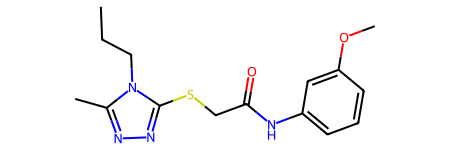

In [ ]:
Chem.MolFromSmiles(smiles_list[1000], sanitize=False)

In [32]:
def check_validity(smiles_list):
    from rdkit import Chem
    valid_smiles = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            valid_smiles.append(smiles)
    return valid_smiles

In [33]:
# Get the non valid molecules

valid_smiles = check_validity(smiles_list)
non_valid_smiles = list(set(smiles_list) - set(valid_smiles))
len(valid_smiles)

2000

In [ ]:
# Get the average number of atoms in the list 
import numpy as np
def get_average_number_atoms(smiles_list):
    from rdkit import Chem
    n_atoms = []
    max_atoms = 0
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        n_atoms.append(mol.GetNumAtoms())
        if mol.GetNumAtoms() > max_atoms:
            max_atoms = mol.GetNumAtoms()
    return np.mean(n_atoms), max_atoms

In [ ]:
get_average_number_atoms(smiles_list)

(22.4915, 40)

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

def plot_molecules(df, num_mols=100):
    mols = [Chem.MolFromSmiles(smiles) for smiles in df.iloc[:,0].head(num_mols)]
    return Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), useSVG=True)


c:\Users\goupi\.conda\envs\torch_geometric\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


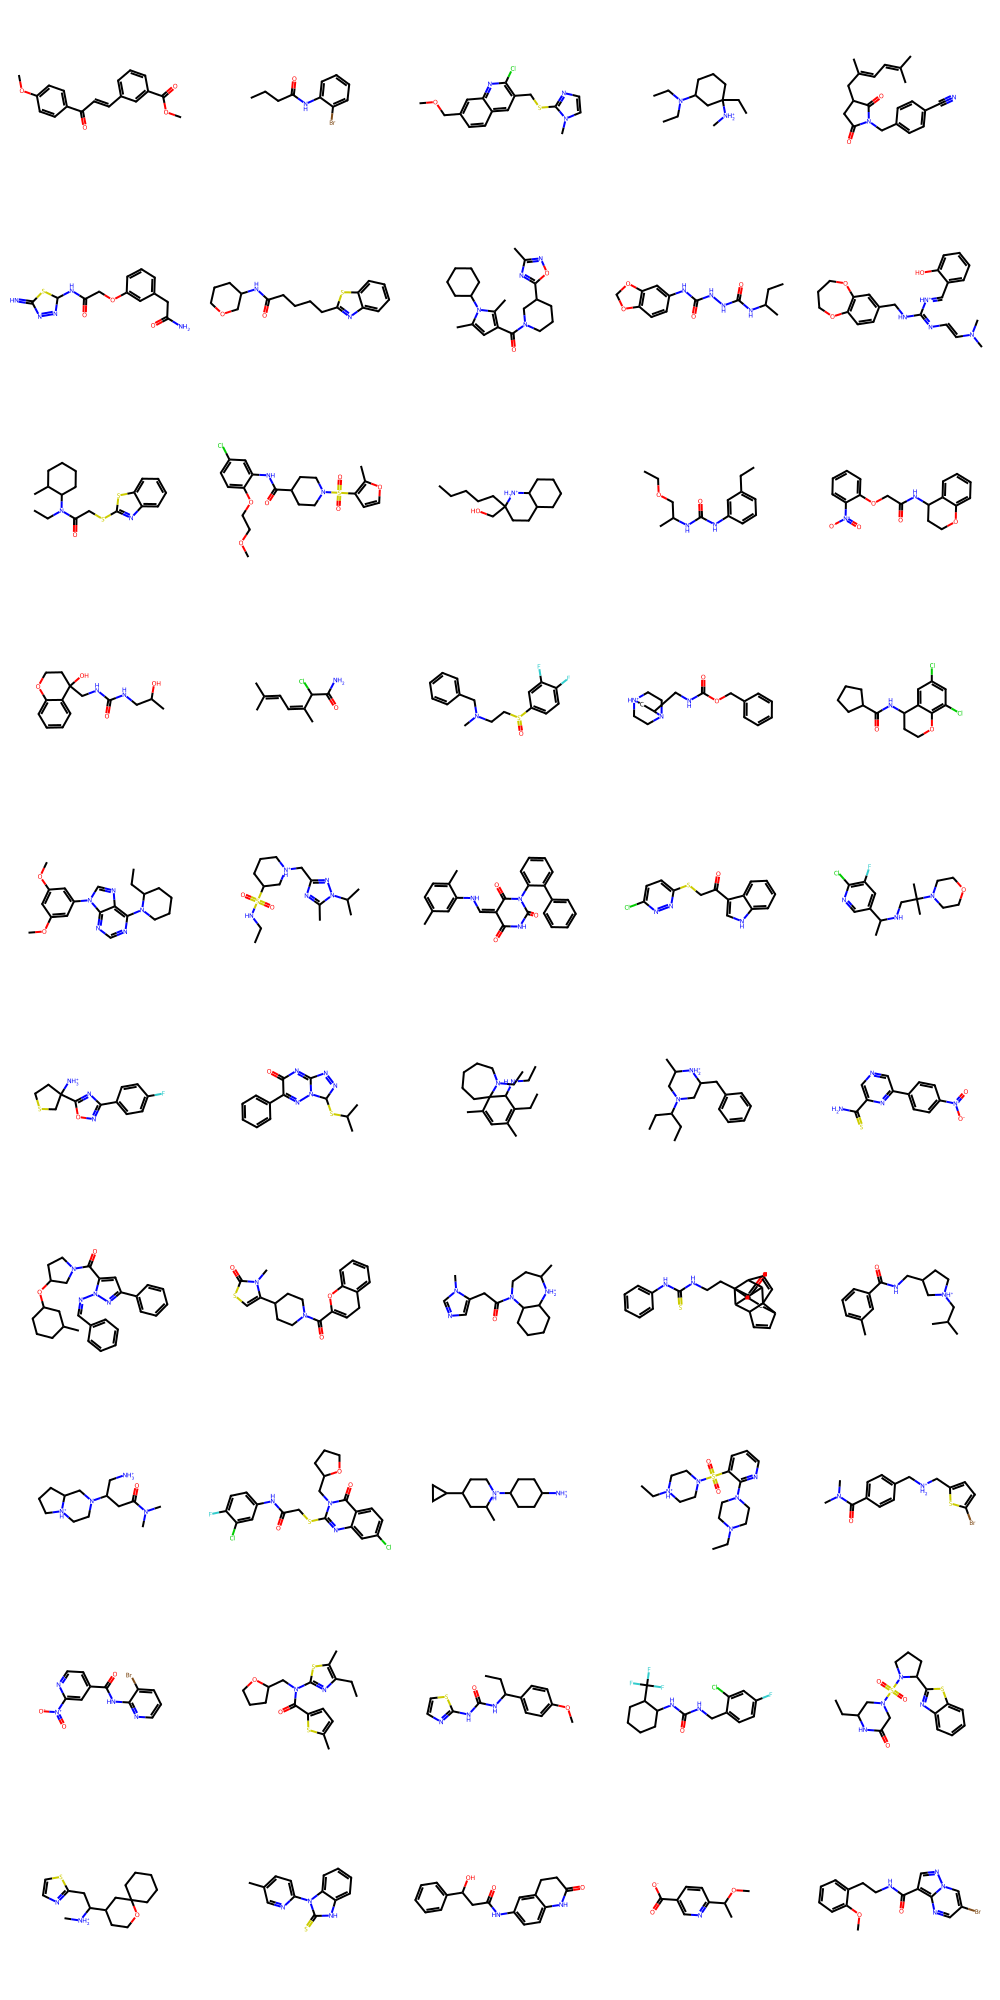

In [ ]:
import pandas as pd
plot_molecules(pd.DataFrame(smiles_list[:]))

In [ ]:
def get_node_indices_in_batch(current_node_tensor, batch):
    indices = torch.zeros(len(current_node_tensor), dtype=torch.long)
    # Iterating over current_node_tensor
    for i, node in enumerate(current_node_tensor):
        indices[i] = (torch.where(batch == i)[0][node.item()])
    return indices

from torch_geometric.data import Batch
batch_graph = Batch()
batch_graph.batch = torch.tensor([0,1,2,3,4,0,2,3,4,0,1,3,4,0,1,2,4,0,1,2,3])
current_nodes_tensor = torch.tensor([2,1,3,3,0])

get_node_indices_in_batch(current_nodes_tensor, batch_graph.batch)

tensor([ 9, 10, 19, 20,  4])

In [ ]:
def return_current_nodes_batched(current_node_tensor, batch):
    # Get the unique graph ids
    unique_graph_ids = torch.unique(batch)
    # Create a 2D mask that shows where each graph's nodes are located in batch
    mask = batch[None, :] == unique_graph_ids[:, None]
    # Compute the cumulative sum of the mask along the sec ond dimension
    cumulative_mask = mask.cumsum(dim=1)
    print(cumulative_mask)
    # Now, for each graph, the nodes are numbered from 1 to N (or 0 to N-1 if we subtract 1)
    node_indices_per_graph = cumulative_mask - 1
    print(node_indices_per_graph)
    # But we only want the indices of certain nodes (specified by current_node_tensor)
    # So we create a mask that is True where the node index equals the current node index for the graph
    current_node_mask = node_indices_per_graph == current_node_tensor[:, None]
    # The result is the indices in batch where current_node_mask is True
    # Find the arg of the first True in each row
    result = torch.argmax(current_node_mask.int(), dim=1)
    return result

In [ ]:
return_current_nodes_batched(current_nodes_tensor, batch_graph.batch)

tensor([[1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4],
        [0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4],
        [0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4],
        [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4]])
tensor([[ 0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,
          4,  4,  4],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,
          3,  3,  3],
        [-1, -1,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
          2,  3,  3],
        [-1, -1, -1,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  3],
        [-1, -1, -1, -1,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,
          3,  3,  3]])


tensor([ 9, 10, 19, 20,  4])

In [ ]:
import torch

# batch tensor that maps each node to a graph
batch = torch.tensor([0, 1, 0, 1, 0, 0, 0, 2, 3, 4])

# tensor of embeddings for each graph
embeddings = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5])

# duplicate graph embeddings based on the batch tensor
output = embeddings[batch]

print(output)

tensor([0.1000, 0.2000, 0.1000, 0.2000, 0.1000, 0.1000, 0.1000, 0.3000, 0.4000,
        0.5000])


In [ ]:
random.choice(range(1, 10))

4

In [ ]:
from torch_scatter import scatter_add

In [ ]:
def masked_global_add_pool(x, batch, mask):
    # Convert the graph mask into a node mask
    node_mask = mask[batch]
    # Mask the node features and the batch tensor
    x_masked = x[node_mask]
    batch_masked = batch[node_mask]
    # Perform the scatter add operation on the masked tensors
    pooled = scatter_add(x_masked, batch_masked, dim=0, dim_size=batch.max().item() + 1)
    # Replace the pooled vectors of the masked out graphs with zeros
    pooled[~mask, :] = 0

    return pooled

In [ ]:
def masked_global_add_pool(x, batch, mask):
    # Create a mapping from old to new batch indices
    indices = torch.arange(len(mask), device=mask.device)
    valid_indices = indices[mask]
    map_indices = torch.full((len(mask),), -1, dtype=torch.long, device=mask.device)
    map_indices[valid_indices] = torch.arange(len(valid_indices), device=mask.device)

    # Update the batch tensor according to the mapping
    batch_mapped = map_indices[batch]
    valid_node_mask = batch_mapped >= 0
    x_masked = x[valid_node_mask]
    batch_masked = batch_mapped[valid_node_mask]

    # Perform the scatter_add operation on the masked tensors
    pooled = scatter_add(x_masked, batch_masked, dim=0, dim_size=batch_masked.max().item() + 1)

    # Create an output tensor filled with zeros and add the valid pooled vectors
    out = torch.zeros((len(mask), x.size(1)), device=x.device)
    out[mask] = pooled

    return out

In [ ]:
x = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12], [13, 14, 15]], dtype=torch.float)

batch = torch.tensor([0, 0, 1, 2, 2])
    
mask = torch.tensor([True, False, True])

masked_global_add_pool(x, batch, mask)

tensor([[ 5.,  7.,  9.],
        [ 0.,  0.,  0.],
        [23., 25., 27.]])